In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn

device = "cpu"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics
import sys
sys.path.append('..')  # access dmc in parent dir
from dmc import make_dmc_env

def make_env():
	def thunk():
		# Create environment with state observations
		env_name = "cartpole-balance"
		env = make_dmc_env(env_name, np.random.randint(0, 1000000), flatten=True, use_pixels=False)
		# warppers
		env = RecordEpisodeStatistics(env, buffer_length=1000)
		return env

	return thunk

/tmp2/b10902111/miniconda3/envs/rl/lib/python3.10/site-packages/glfw/__init__.py:917: GLFWError: (65550) b'Failed to detect any supported platform'
  warnings.warn(message, GLFWError)
/tmp2/b10902111/miniconda3/envs/rl/lib/python3.10/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists


In [3]:
env = make_env()()
print(f'''
[Action]
     {env.action_space}: {env.action_space.sample()}
[Observation]
     {env.observation_space}: {env.observation_space.sample()}
'''.strip())
env.close()

[Action]
     Box(-1.0, 1.0, (1,), float64): [-0.26513782]
[Observation]
     Box(-inf, inf, (5,), float64): [ 1.45682798  0.43805428 -0.3762297   1.03003791 -1.42336689]


# Networks

In [4]:
class Qnet(nn.Module):
    def __init__(self, envs) -> None:
        super(Qnet, self).__init__()
        n_observation = int(np.prod(envs.single_observation_space.shape))
        n_action = int(np.prod(envs.single_action_space.shape))

        self.fc = nn.Sequential(
            nn.Linear(n_observation + n_action, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        state_action = torch.cat([state, action], dim=1)
        return self.fc(state_action)

In [5]:
envs = gym.vector.SyncVectorEnv([make_env()])
torch.jit.script(Qnet(envs))

RecursiveScriptModule(
  original_name=Qnet
  (fc): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=Linear)
  )
)

In [6]:
# reference: ClearRL
class Actor(nn.Module):
    def __init__(self, envs) -> None:
        super().__init__()
        n_observation = int(np.prod(envs.single_observation_space.shape))
        n_action = int(np.prod(envs.single_action_space.shape))
        action_high = envs.single_action_space.high
        action_low = envs.single_action_space.low

        self.fc = nn.Sequential(
            nn.Linear(n_observation, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
        )
        self.fc_mean = nn.Linear(32, n_action)
        self.fc_logstd = nn.Linear(32, n_action) # log std is more stable
        self.LOG_STD_MAX = 2
        self.LOG_STD_MIN = -5  # maybe -20

        # action rescaling
        self.register_buffer(
            "action_scale",
            torch.tensor((action_high - action_low) / 2.0, dtype=torch.float32),
        )
        self.register_buffer(
            "action_bias",
            torch.tensor((action_high + action_low) / 2.0, dtype=torch.float32),
        )

    def forward(self, state: torch.Tensor) -> tuple:
        # get mean, std
        x = self.fc(state)
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = self.LOG_STD_MIN + 0.5 * (self.LOG_STD_MAX - self.LOG_STD_MIN) * (log_std + 1)
        std = log_std.exp()

        # get action, log_prob
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t) # output between [-1, 1]
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        # mean is deterministic action
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean

In [7]:
obs = envs.single_observation_space.sample()
sample_input = torch.tensor(np.array([obs]), device=device, dtype=torch.float32)
torch.jit.trace(Actor(envs).to(device), sample_input)
env.close()

/tmp2/b10902111/miniconda3/envs/rl/lib/python3.10/site-packages/torch/jit/_trace.py:1307: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(1, 1, strides=[1, 1], requires_grad=0, device=cpu) = aten::normal(%73, %81, %82) # /tmp2/b10902111/miniconda3/envs/rl/lib/python3.10/site-packages/torch/distributions/utils.py:63:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  _check_trace(
/tmp2/b10902111/miniconda3/envs/rl/lib/python3.10/site-packages/torch/jit/_trace.py:1307: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 1 / 1 (100.0%)
Greatest absolute difference: 0.2615000605583191 at index (0, 0) (up to 1e-05 allowed)
Greatest relative difference: 1.8931899962511562 at index (0, 0) (up to 1e-05 allowed)
  _check_trace(
/tmp2/b10902

# Agent

In [8]:
import os
from tensordict import tensorclass
from torchrl.data import ReplayBuffer, LazyTensorStorage


@tensorclass
class Transition:
    observation: torch.Tensor
    action: torch.Tensor
    reward: torch.Tensor
    next_obs: torch.Tensor
    done: torch.Tensor


class SACAgent:
    def __init__(
        self,
        envs,
        q_learning_rate: float = 1e-3,
        actor_learning_rate: float = 3e-4,
        replay_buffer_size: int = 20000,
        batch_size: int = 64,
        gamma: float = 0.99,
        tau: float = 5e-3,
        policy_update_freq: float = 2,
        target_update_freq: float = 2,
        use_jit: bool = True,
    ):
        self.use_jit = use_jit

        # networks
        self.actor = Actor(envs).to(device)
        self.q1 = Qnet(envs).to(device)
        self.q2 = Qnet(envs).to(device)
        self.target_q1 = Qnet(envs).to(device)
        self.target_q2 = Qnet(envs).to(device)
        self.target_q1.load_state_dict(self.q1.state_dict())
        self.target_q2.load_state_dict(self.q2.state_dict())
        if use_jit:
            self._make_jit_models(envs)
        self.target_q1.eval()
        self.target_q2.eval()

        self.q_optimizer = optim.Adam(
            list(self.q1.parameters()) + list(self.q2.parameters()), lr=q_learning_rate
        )
        self.actor_optimizer = optim.Adam(
            self.actor.parameters(), lr=actor_learning_rate
        )

        # automatic alpha tuning
        self.TARGET_ENTROPY = -torch.prod(torch.Tensor(env.action_space.shape).to(device)).item()
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device) # log is more stable
        self.alpha = self.log_alpha.exp().item()
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=q_learning_rate)

        # hyperparameters
        self.gamma = gamma
        self.tau = tau
        self.policy_update_freq = policy_update_freq
        self.target_update_freq = target_update_freq
        self.replay_buffer = ReplayBuffer(
            storage=LazyTensorStorage(replay_buffer_size, device=device),
            batch_size=batch_size,
            prefetch=10,
        )
    
    def _make_jit_models(self, envs) -> None:
        obs = envs.single_observation_space.sample()
        sample_input = torch.tensor([obs], device=device, dtype=torch.float32)
        self.actor = torch.jit.trace(self.actor, sample_input)
        self.q1 = torch.jit.script(self.q1)
        self.q2 = torch.jit.script(self.q2)
        self.target_q1 = torch.jit.script(self.target_q1)
        self.target_q2 = torch.jit.script(self.target_q2)
    
    def _update_q(self, batch: Transition) -> None:
        with torch.no_grad():
            sampled_action, log_prob, _ = self.actor(batch.next_obs)
            q_value_1 = self.target_q1(batch.next_obs, sampled_action)
            q_value_2 = self.target_q2(batch.next_obs, sampled_action)
            min_q_value = torch.min(q_value_1, q_value_2) - self.alpha * log_prob
            target_q_value = batch.reward + self.gamma * (1 - batch.done) * min_q_value

        q1_value = self.q1(batch.observation, batch.action)
        q2_value = self.q2(batch.observation, batch.action)
        q1_loss = F.mse_loss(q1_value, target_q_value)
        q2_loss = F.mse_loss(q2_value, target_q_value)
        total_q_loss = q1_loss + q2_loss

        self.q_optimizer.zero_grad()
        total_q_loss.backward()
        self.q_optimizer.step()

    def _update_actor(self, batch: Transition) -> None:
        sampled_action, log_prob, _ = self.actor(batch.observation)
        q_value_1 = self.q1(batch.observation, sampled_action)
        q_value_2 = self.q2(batch.observation, sampled_action)
        min_q_value = torch.min(q_value_1, q_value_2)  # detach?
        loss = (self.alpha * log_prob - min_q_value).mean()

        self.actor_optimizer.zero_grad()
        loss.backward()
        self.actor_optimizer.step()

        # automatic alpha tuning
        with torch.no_grad():
            _, log_prob, _ = self.actor(batch.observation)
        alpha_loss = (-self.log_alpha.exp() * (log_prob + self.TARGET_ENTROPY)).mean()

        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        self.alpha = self.log_alpha.exp().item()

    def _update_target_net(self) -> None:
        for param, target_param in zip(self.q1.parameters(), self.target_q1.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        for param, target_param in zip(self.q2.parameters(), self.target_q2.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def learn(self, global_step: int) -> None:
        batch = self.replay_buffer.sample()
        self._update_q(batch)
        if global_step % self.policy_update_freq == 0:
            for _ in range(self.policy_update_freq):
                self._update_actor(batch)
        if global_step % self.target_update_freq == 0:
            self._update_target_net()
    
    def get_action(self, observation: torch.Tensor):
        sampled_action, _, _ = self.actor(observation)
        return sampled_action.detach().cpu().numpy()
    
    def memorize(self, transition: Transition) -> None:
        self.replay_buffer.extend(transition)
    
    def save(self, dir_name: str) -> None:
        os.makedirs(dir_name, exist_ok=True)

        if self.use_jit:
            torch.jit.save(self.actor, f"{dir_name}/actor.pt")
            torch.jit.save(self.q1, f"{dir_name}/q1.pt")
            torch.jit.save(self.q2, f"{dir_name}/q2.pt")
        else:
            torch.save(self.actor.state_dict(), f"{dir_name}/actor.pt")
            torch.save(self.q1.state_dict(), f"{dir_name}/q1.pt")
            torch.save(self.q2.state_dict(), f"{dir_name}/q2.pt")

    def load(self, dir_name: str) -> None:
        if self.use_jit:
            self.actor = torch.jit.load(f"{dir_name}/actor.pt", map_location=device)
            self.q1 = torch.jit.load(f"{dir_name}/q1.pt", map_location=device)
            self.q2 = torch.jit.load(f"{dir_name}/q2.pt", map_location=device)
        else:
            self.actor.load_state_dict(torch.load(f"{dir_name}/actor.pt", map_location=device))
            self.q1.load_state_dict(torch.load(f"{dir_name}/q1.pt", map_location=device))
            self.q2.load_state_dict(torch.load(f"{dir_name}/q2.pt", map_location=device))
        
        self.target_q1.load_state_dict(self.q1.state_dict())
        self.target_q2.load_state_dict(self.q2.state_dict())
    
    def eval(self) -> None:
        self.actor.eval()
        self.q1.eval()
        self.q2.eval()
    
    def train(self) -> None:
        self.actor.train()
        self.q1.train()
        self.q2.train()

# Training

In [9]:
num_envs = 2
envs = gym.vector.SyncVectorEnv(
    [make_env() for _ in range(num_envs)]
)
agent = SACAgent(envs)

/tmp/ipykernel_2108349/350529683.py:70: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  sample_input = torch.tensor([obs], device=device, dtype=torch.float32)
/tmp2/b10902111/miniconda3/envs/rl/lib/python3.10/site-packages/torch/jit/_trace.py:1307: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(1, 1, strides=[1, 1], requires_grad=0, device=cpu) = aten::normal(%73, %81, %82) # /tmp2/b10902111/miniconda3/envs/rl/lib/python3.10/site-packages/torch/distributions/utils.py:63:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  _check_trace(
/tmp2/b10902111/miniconda3/envs/rl/lib/python3.10/site-packages/torch/jit/_trace.py:1307: TracerWarning: Output

In [10]:
total_steps = 100000
warm_up_steps = 1000
returns = []

observations, info = envs.reset()
observations = torch.tensor(observations, device=device, dtype=torch.float32)
for step in range(1, total_steps + 1):
    # select action and act
    if step < warm_up_steps:
        actions = envs.action_space.sample().astype(np.float32)
    else:
        actions = agent.get_action(observations)
    next_obss, rewards, terminated, truncated, info = envs.step(actions)
    next_obss = torch.tensor(next_obss, device=device, dtype=torch.float32)
    done = (terminated | truncated)

    # save transition to replay buffer
    transitions = Transition(
        observation = observations,
        action = torch.tensor(actions, dtype=torch.float32),
        reward = torch.tensor(rewards, dtype=torch.float32).unsqueeze_(-1),
        next_obs = next_obss,
        done = torch.tensor(terminated, dtype=torch.float32).unsqueeze_(-1),
        batch_size=[num_envs],
    )
    agent.memorize(transitions)

    # update models
    if step > warm_up_steps:
        agent.learn(step)

    if any(done):
        # log
        print(f"[{step}], alpha={agent.alpha:.3f}, {info['episode']}")
        returns.extend(info["episode"]["r"].tolist())
        observations, info = envs.reset()
        observations = torch.tensor(observations, device=device, dtype=torch.float32)
        continue

    observations = next_obss

[1000], alpha=1.000, {'r': array([365.2269311 , 359.48913198]), '_r': array([ True,  True]), 'l': array([1000, 1000]), '_l': array([ True,  True]), 't': array([1.9424  , 1.942327]), '_t': array([ True,  True])}
[2000], alpha=0.431, {'r': array([334.5877714 , 362.37265878]), '_r': array([ True,  True]), 'l': array([1000, 1000]), '_l': array([ True,  True]), 't': array([11.21355 , 11.213538]), '_t': array([ True,  True])}
[3000], alpha=0.232, {'r': array([259.14605446, 395.54308945]), '_r': array([ True,  True]), 'l': array([1000, 1000]), '_l': array([ True,  True]), 't': array([10.60487 , 10.604853]), '_t': array([ True,  True])}
[4000], alpha=0.138, {'r': array([399.80000495, 396.90971318]), '_r': array([ True,  True]), 'l': array([1000, 1000]), '_l': array([ True,  True]), 't': array([10.559328, 10.559615]), '_t': array([ True,  True])}
[5000], alpha=0.086, {'r': array([243.44837133, 490.92431757]), '_r': array([ True,  True]), 'l': array([1000, 1000]), '_l': array([ True,  True]), 't

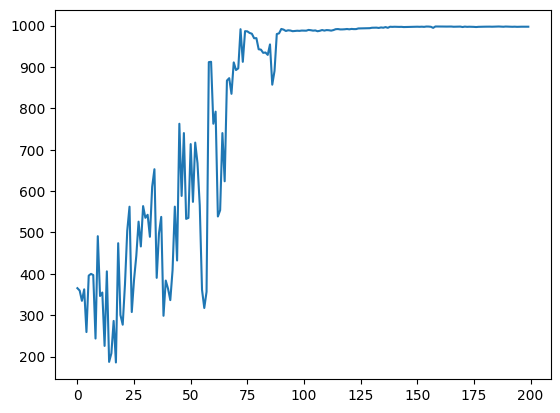

In [11]:
plt.plot(returns)

In [12]:
agent.save("sac_test_ckpt")